In [37]:
import torch
import pandas as pd
import sklearn
import torch



In [38]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")   # Use CPU
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [39]:
from torch.utils.data import Dataset

class ChessData(Dataset):
    def __init__(self, board_datafile, move_datafile):
        self.chess_boards = torch.load(board_datafile)
        self.chess_moves = torch.load(move_datafile)

    def __len__(self):
        return len(self.chess_boards)

    def __getitem__(self, index):
        input_board = self.chess_boards[index]
        output_pos = self.chess_moves[index]
        return input_board, output_pos
    






    

In [40]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [41]:
chess_data = ChessData("datasets/chess_boards_m1_v4.pt", "datasets/chess_moves_m1_v4.pt")

In [42]:
class StableSoftmax(nn.Module):
    def forward(self, x):
        x = x - x.max(dim=-1, keepdim=True).values
        return torch.softmax(x, dim=-1)

class Softermax(nn.Module):
    def __init__(self, dim=1):
        super(Softermax, self).__init__()
        self.dim = dim

    def forward(self, x):
        softplus_x = F.softplus(x)  # Applying softplus to each element in x
        return softplus_x / torch.sum(softplus_x, dim=self.dim, keepdim=True)

class Chess_CNN(nn.Module):
    def __init__(self):
        super(Chess_CNN, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 32, 1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 64)
        self.smax = Softermax()

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.relu1(x)
        # x = self.conv2(x)
        # x = self.relu2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        #x = nn.functional.softmax(x, dim=1)
        x = self.smax(x)
        x = x.view(x.size(0), 8, 8)
        return x
    
class Deeper_Chess_CNN(nn.Module):
    def __init__(self):
        super(Deeper_Chess_CNN, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(512, 64)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = nn.functional.softmax(x, dim=1)
        x = x.view(x.size(0), 8, 8)
        return x



In [43]:
torch.manual_seed(123)

# Create a DataLoader for training
batch_size = 64
# Split the dataset into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(chess_data))), test_size=0.2, random_state=42)

# Create Samplers for train and validation sets
train_sampler = data.SubsetRandomSampler(train_indices)
val_sampler = data.SubsetRandomSampler(val_indices)

# Create DataLoaders for train and validation sets
train_loader = DataLoader(chess_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(chess_data, batch_size=batch_size, sampler=val_sampler)

In [46]:
def entropy(prob_tensor):
    # Flatten the tensor to consider all elements and compute the entropy
    flat_probs = prob_tensor.view(-1)
    return -torch.sum(flat_probs * torch.log2(flat_probs + 1e-9))

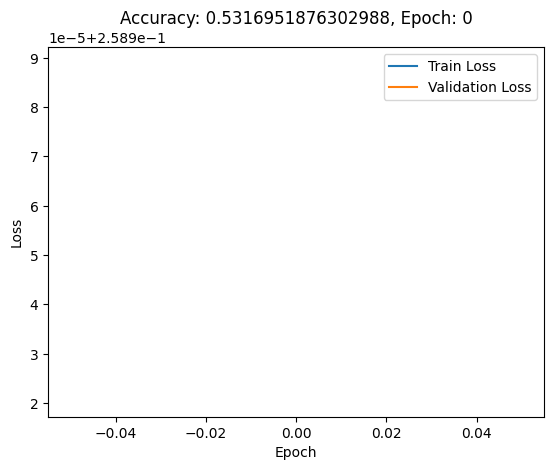

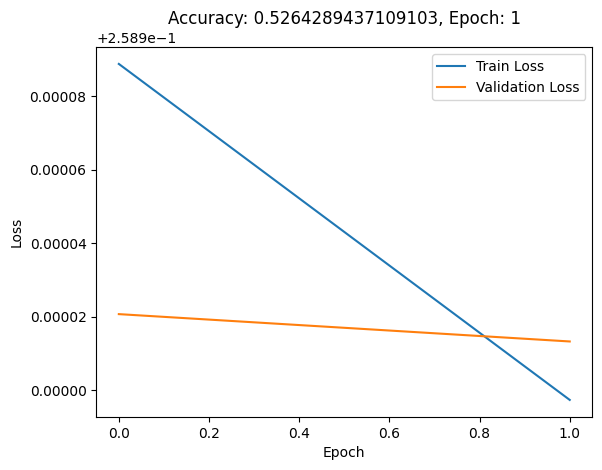

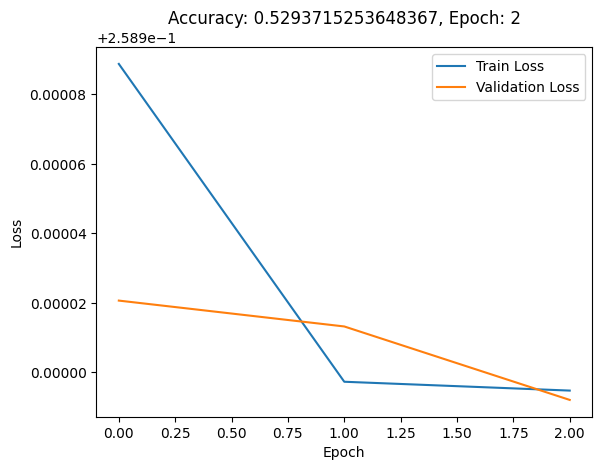

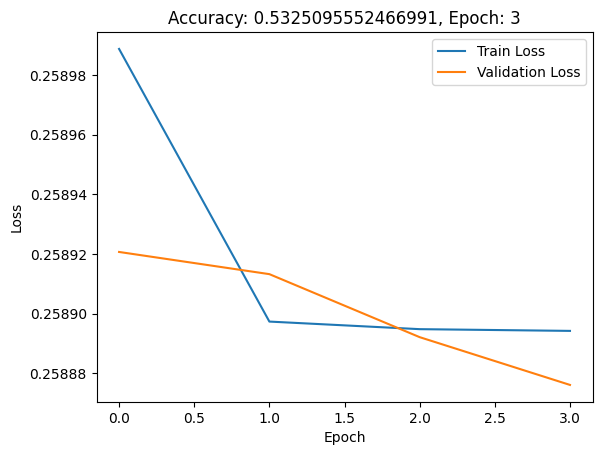

KeyboardInterrupt: 

In [61]:
lr = 10 ** -2
entropy_coeff = 10 ** -3


# Initialize your neural network
model = Chess_CNN()

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.000001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)


loss_hist = []
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    total_batches = 0
    for inputs, targets in train_loader:
        targets = targets.float().to(device)
        inputs = inputs.float().to(device)


        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        total_loss += loss.item()
        total_batches += 1  

        loss -= entropy_coeff * entropy(outputs)
        #print(entropy(outputs))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Track avg loss
        
    
    avg_loss_train = total_loss / total_batches

    total_loss_val = 0
    total_batches_val = 0

    for inputs, targets in val_loader:
        targets = targets.float().to(device)
        inputs = inputs.float().to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Track avg loss
        total_loss_val += loss.item()
        total_batches_val += 1
    
    avg_loss_val = total_loss_val / total_batches_val

    scheduler.step(avg_loss_val)

    # Print progress
    #print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Accuracy: {accuracy}")
    loss_hist.append((epoch, avg_loss_train, avg_loss_val))

    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_outputs = val_outputs.view(batch_size, -1)
            val_targets = val_targets.view(batch_size, -1)
            _, predicted_labels = torch.max(val_outputs, dim=1)
            _, target_labels = torch.max(val_targets, dim=1)

            total_correct += (predicted_labels == target_labels).sum().item()
            total_samples += val_targets.size(0)

    accuracy = total_correct / total_samples

    # Extract the epoch and loss values from the data
    epochs, train_losses, val_losses = zip(*loss_hist)

    # Create the plot
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    # Set the plot labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Accuracy: {accuracy}, Epoch: {epoch}')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()





In [60]:
torch.save(model.state_dict(), "models/m1_v11.pth")